In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import os
import sys
from pathlib import Path

path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))

from src.data.save_results import save_model_scores, save_model_predictions
from src.utils.data_loader import load_preprocessed_data

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
DATA = path / "data"
TRAINED_DATA = DATA / "trained_data"
MODELS = DATA / "models"
METHOD = "SingleOutput"


In [3]:

# Define multiple scorings
cv_scorings = {
    "CV R2": "r2"
}

target_variables = [
    "temperature_2m",
    "apparent_temperature",
    "relative_humidity_2m",
    "wind_speed_10m",
    "wind_direction_10m_sin",
    "wind_direction_10m_cos",
    "rain",
    "shortwave_radiation"
]

In [ ]:
# Tạo pipeline gồm scaler + SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Lưới các siêu tham số cần thử
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.1, 1]
}

# Grid search với 5-fold cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',  # dùng chỉ số R2 để đánh giá
    n_jobs=-1,     # chạy song song
    verbose=2      # in thông tin trong quá trình chạy
)

target_variables = [
    "temperature_2m",
    "apparent_temperature",
    "relative_humidity_2m",
    "wind_speed_10m",
    "wind_direction_10m_sin",
    "wind_direction_10m_cos",
    "rain",
    "shortwave_radiation"
]

for target_variable in target_variables:
    print(f"[INFO] Running grid search for target: {target_variable}")
    data = load_preprocessed_data(method=METHOD, target_variable=target_variable)

    X_train = data["X_train"]
    y_train = data["y_train"]

    X_train_subsample, _, Y_train_subsample, _ = train_test_split(X_train, y_train, train_size=10000, random_state=42)

    # Huấn luyện
    grid_search.fit(X_train_subsample, Y_train_subsample)

    # Kết quả
    print(f"Best parameters - {target_variable}:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)

In [ ]:
# Fitting 5 folds for each of 36 candidates, totalling 180 fits
# Best parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__gamma': 'scale'}
# Best R2 score: 0.7967943692034016

# [INFO] Running grid search for target: wind_direction_10m_sin
# Fitting 5 folds for each of 36 candidates, totalling 180 fits
# Best parameters - wind_direction_10m_sin: {'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 0.1}
# Best R2 score: 0.9037051888714049
# [INFO] Running grid search for target: rain
# Fitting 5 folds for each of 36 candidates, totalling 180 fits
# Best parameters - rain: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
# Best R2 score: 0.2151197616867031

In [ ]:
for target_variable in target_variables:
    data = load_preprocessed_data(method=METHOD, target_variable=target_variable)

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    preprocessor = data["preprocessor"]

    X_train_subsample = X_train[-100000:]
    Y_train_subsample = y_train[-100000:]

    if target_variable in ("wind_direction_10m_sin", "wind_direction_10m_cos"):
        svr_C = 1
        svr_epsilon = 0.01
        svr_gamma = 0.1
    elif target_variable == "rain":
        svr_C = 10
        svr_epsilon = 0.1
        svr_gamma = 'scale'
    else:
        svr_C = 10.0
        svr_epsilon = 1.0
        svr_gamma = 'scale'
    
    # Pipeline cho SVR
    svr_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", SVR(kernel='rbf', C=svr_C, epsilon=svr_epsilon, gamma=svr_gamma))
    ])

    tscv = TimeSeriesSplit(n_splits=3)

    # Dictionary to store CV results
    cv_results = {}

    for name, scoring in cv_scorings.items():
        scores = cross_val_score(
            svr_pipeline, X_train_subsample, Y_train_subsample,
            cv=tscv, scoring=scoring, n_jobs=-1
        )
        mean_score = -np.mean(scores) if "neg_" in scoring else np.mean(scores)
        std_score = np.std(scores)
        cv_results[name] = (mean_score, std_score)

    # Train and evaluate on test set
    svr_pipeline.fit(X_train_subsample, Y_train_subsample)
    y_pred_svr = svr_pipeline.predict(X_test)

    mae_svr = mean_absolute_error(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
    r2_svr = r2_score(y_test, y_pred_svr)

    y_train_pred = svr_pipeline.predict(X_train_subsample)
    r2_train = r2_score(Y_train_subsample, y_train_pred)

    # Transform X_train_subsample via preprocessor to calculate VIF
    X_train_transformed = preprocessor.fit_transform(X_train_subsample)
    if hasattr(X_train_transformed, "toarray"):
        X_train_transformed = X_train_transformed.toarray()

    X_vif = pd.DataFrame(X_train_transformed)
    vif_data = pd.DataFrame()
    vif_data["feature_index"] = range(X_vif.shape[1])
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

    # === Print results ===
    print(f"[RESULT] Support Vector Regression - {target_variable}")
    print("Cross-Validation Scores:")
    for name, (mean_score, std_score) in cv_results.items():
        print(f"  [{name}]: {mean_score:.2f} ± {std_score:.2f}")
    print("\nTest Set Evaluation:")
    print(f"  [MAE]: {mae_svr:.2f}")
    print(f"  [RMSE]: {rmse_svr:.2f}")
    print(f"  [Train R2 Score]: {r2_train:.2f}")
    print(f"  [Test R2 Score]: {r2_svr:.2f}")
    print("\n[VIF Scores]")
    print(vif_data.sort_values("VIF", ascending=False).head(20))

    # === Save results ===
    PATH = DATA / "scores&predictions" / METHOD / target_variable
    save_model_scores(
        model_name="SupportVectorRegression",
        save_dir=PATH,
        mae=mae_svr,
        rmse=rmse_svr,
        r2=r2_svr,
        cv_rmse_mean=cv_results["CV RMSE"][0],  # mean RMSE
        cv_rmse_std=cv_results["CV RMSE"][1],  # std RMSE
        cv_mae_mean=cv_results["CV MAE"][0],  # mean MAE
        cv_mae_std=cv_results["CV MAE"][1],  # std MAE
        cv_r2_mean=cv_results["CV R2"][0],  # mean R2
        cv_r2_std=cv_results["CV R2"][1]  # std R2
    )
    save_model_predictions("SupportVectorRegression", y_test, y_pred_svr, PATH)


[RESULT] Support Vector Regression - temperature_2m
Cross-Validation Scores:
  [CV RMSE]: 2.62 ± 0.09
  [CV MAE]: 1.94 ± 0.06
  [CV R2]: 0.79 ± 0.02

Test Set Evaluation:
  [MAE]: 2.02
  [RMSE]: 2.71
  [Train R2 Score]: 0.83
  [Test R2 Score]: 0.77

[VIF Scores]
    feature_index       VIF
1               1  3.519413
2               2  2.974735
3               3  2.708833
0               0  2.631110
9               9  2.571586
8               8  2.553517
10             10  2.175534
6               6  2.008200
7               7  1.791884
12             12  1.747025
4               4  1.319913
5               5  1.249252
11             11  1.102215
[RESULT] Support Vector Regression - apparent_temperature
Cross-Validation Scores:
  [CV RMSE]: 3.79 ± 0.12
  [CV MAE]: 2.81 ± 0.08
  [CV R2]: 0.79 ± 0.02

Test Set Evaluation:
  [MAE]: 2.98
  [RMSE]: 3.99
  [Train R2 Score]: 0.83
  [Test R2 Score]: 0.77

[VIF Scores]
    feature_index       VIF
1               1  3.519413
2               2  2

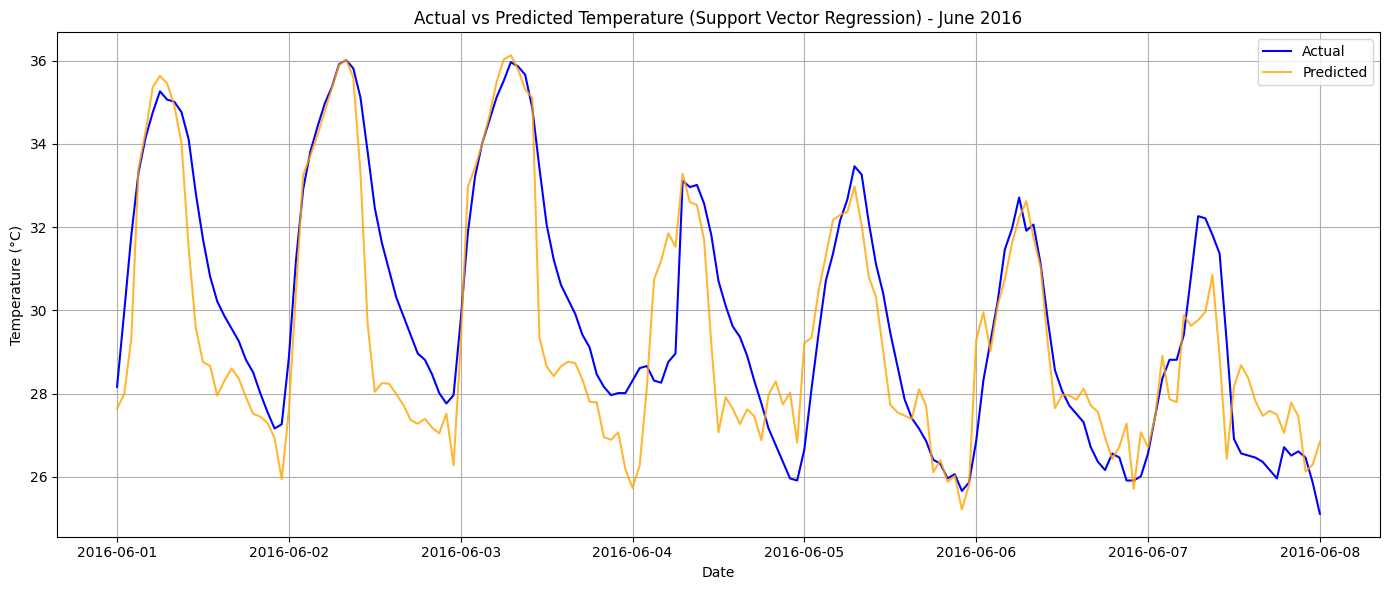

In [4]:
# Đọc dữ liệu và chuyển đổi cột date
test_df = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/temperature_2m/test_df.csv", parse_dates=["date"])
model_predictions = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/temperature_2m/model_predictions.csv")

# Kiểm tra điều kiện: actual == temperature_2m_max
matching = model_predictions["actual"].values == test_df["temperature_2m"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions["date"] = np.where(
    matching,
    test_df["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions["date"] = pd.to_datetime(model_predictions["date"], errors="coerce")

# Lọc khoảng thời gian từ 01/01/2016 đến 31/12/2016
mask = (model_predictions["date"] >= "2016-06-01") & (model_predictions["date"] <= "2016-06-08")
subset_df = model_predictions[mask]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(subset_df["date"], subset_df["actual"], label="Actual", color="blue")
plt.plot(subset_df["date"], subset_df["SupportVectorRegression_pred"], label="Predicted", color="orange", alpha=0.8)
plt.title("Actual vs Predicted Temperature (Support Vector Regression) - June 2016")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


[MAE]: 0.20 rad ~ 11.68°
[RMSE]: 0.78 rad ~ 44.48°
[R2]: 0.74


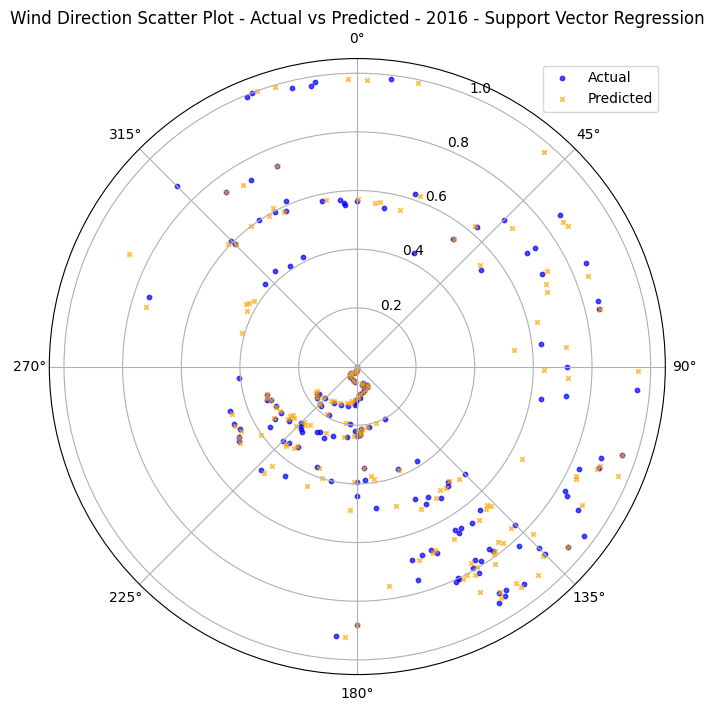

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

matching = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_sin["date"] = np.where(
    matching,
    test_df_sin["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

matching = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_cos["date"] = np.where(
    matching,
    test_df_cos["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Chuyển hướng gió sang radian
theta_actual = np.arctan2(model_predictions_sin["actual"], model_predictions_cos["actual"])
theta_pred = np.arctan2(model_predictions_sin["SupportVectorRegression_pred"],
                        model_predictions_cos["SupportVectorRegression_pred"])

mae_wind_direction_10m = mean_absolute_error(theta_actual, theta_pred)
rmse_wind_direction_10m = np.sqrt(mean_squared_error(theta_actual, theta_pred))
r2_wind_direction_10m = r2_score(theta_actual, theta_pred)

print(f"[MAE]: {mae_wind_direction_10m:.2f} rad ~ {mae_wind_direction_10m * 180 / np.pi:.2f}°")
print(f"[RMSE]: {rmse_wind_direction_10m:.2f} rad ~ {rmse_wind_direction_10m * 180 / np.pi:.2f}°")
print(f"[R2]: {r2_wind_direction_10m:.2f}")

mask = (model_predictions_sin["date"] >= "2016-06-01") & (model_predictions_sin["date"] <= "2016-06-08")
theta_actual = theta_actual[mask]
theta_pred = theta_pred[mask]
# Dùng bán kính là chỉ số thời gian hoặc ngẫu nhiên để dễ nhìn
r = np.linspace(0, 1, len(theta_actual))

# Vẽ scatter
plt.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.7)
plt.scatter(theta_pred, r, c='orange', s=10, label="Predicted", alpha=0.7, marker='x')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction Scatter Plot - Actual vs Predicted - 2016 - Support Vector Regression")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

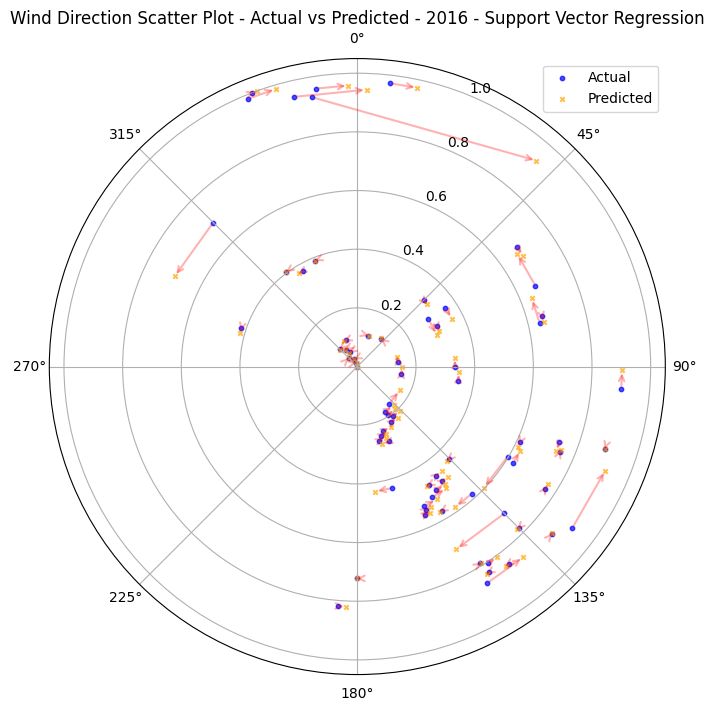

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

matching = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_sin["date"] = np.where(
    matching,
    test_df_sin["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

matching = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_cos["date"] = np.where(
    matching,
    test_df_cos["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Chuyển hướng gió sang radian
theta_actual = np.arctan2(model_predictions_sin["actual"], model_predictions_cos["actual"])
theta_pred = np.arctan2(model_predictions_sin["SupportVectorRegression_pred"],
                        model_predictions_cos["SupportVectorRegression_pred"])

mask = (model_predictions_sin["date"] >= "2016-06-05") & (model_predictions_sin["date"] <= "2016-06-08")
theta_actual = theta_actual[mask]
theta_pred = theta_pred[mask]
# Dùng bán kính là chỉ số thời gian hoặc ngẫu nhiên để dễ nhìn
r = np.linspace(0, 1, len(theta_actual))

for actual, pred, radius in zip(theta_actual, theta_pred, r):
    ax.annotate(
        '',
        xy=(pred, radius),          # Điểm kết thúc (predicted)
        xytext=(actual, radius),    # Điểm bắt đầu (actual)
        arrowprops=dict(
            arrowstyle='->', 
            color='red',
            alpha=0.3,
            lw=1.5
        )
    )

# Vẽ scatter
plt.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.7)
plt.scatter(theta_pred, r, c='orange', s=10, label="Predicted", alpha=0.7, marker='x')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction Scatter Plot - Actual vs Predicted - 2016 - Support Vector Regression")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()